# Imports

In [112]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy.stats import zscore
import scipy.stats as stats
from scipy.stats import chi2_contingency
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_curve, auc
from mlxtend.evaluate import permutation_test
import statsmodels.api as sm

from category_encoders import TargetEncoder

from data_preparation import *
import warnings
warnings.filterwarnings("ignore")

In [33]:
train_prepared = pd.read_csv('./data/train_prepared.csv')
df_app = pd.read_csv('./data/application_train_vf.csv')

train_prepared['SK_ID_CURR'] = df_app['SK_ID_CURR'].copy()
train_prepared['date_mensuelle'] = pd.to_datetime(train_prepared['date_mensuelle'])

train_prepared.drop(columns = 'Unnamed: 0',inplace=True)

train_prepared['CODE_GENDER'] = train_prepared['CODE_GENDER'].apply(lambda x : 'F' if x == 'XNA' else x)


# Bureau

In [34]:
df_bur = pd.read_csv('./data/bureau.csv')

In [35]:
df_bur_group = df_bur[['DAYS_CREDIT', 'CREDIT_DAY_OVERDUE',
       'DAYS_CREDIT_ENDDATE', 'DAYS_ENDDATE_FACT', 'AMT_CREDIT_MAX_OVERDUE',
       'CNT_CREDIT_PROLONG', 'AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT',
       'AMT_CREDIT_SUM_LIMIT', 'AMT_CREDIT_SUM_OVERDUE', 'DAYS_CREDIT_UPDATE',
       'AMT_ANNUITY','SK_ID_CURR']].groupby('SK_ID_CURR').sum()
df_bur_group.reset_index(inplace=True)
df_bur_group['Nombre_credit_actif'] = df_bur[df_bur['CREDIT_ACTIVE'] == 'Active'].pivot_table(index='SK_ID_CURR', columns='CREDIT_ACTIVE', aggfunc='size', fill_value=0)

In [36]:
df_bur_group['Nombre_credit_actif'] = df_bur_group['Nombre_credit_actif'].apply(lambda x : 'Beaucoup de credit actif' if x > 3 else 'Pas de credit actif' if pd.isna(x) else 'Peu de credits actifs')

# Credit_Card

In [37]:
df_cb = pd.read_csv('./data/credit_card_balance.csv')

In [38]:
df_cb_group = df_cb[['SK_ID_CURR', 'MONTHS_BALANCE', 'AMT_BALANCE',
       'AMT_CREDIT_LIMIT_ACTUAL', 'AMT_DRAWINGS_ATM_CURRENT',
       'AMT_DRAWINGS_CURRENT', 'AMT_DRAWINGS_OTHER_CURRENT',
       'AMT_DRAWINGS_POS_CURRENT', 'AMT_INST_MIN_REGULARITY',
       'AMT_PAYMENT_CURRENT', 'AMT_PAYMENT_TOTAL_CURRENT',
       'AMT_RECEIVABLE_PRINCIPAL', 'AMT_RECIVABLE', 'AMT_TOTAL_RECEIVABLE',
       'CNT_DRAWINGS_ATM_CURRENT', 'CNT_DRAWINGS_CURRENT',
       'CNT_DRAWINGS_OTHER_CURRENT', 'CNT_DRAWINGS_POS_CURRENT',
       'CNT_INSTALMENT_MATURE_CUM', 'SK_DPD', 'SK_DPD_DEF']].groupby('SK_ID_CURR').sum()
df_cb_group.reset_index(inplace=True)

# Pos_cash

In [39]:
df_pos = pd.read_csv('./data/POS_CASH_balance.csv')

In [40]:
df_pos_group = df_pos[['SK_ID_CURR', 'MONTHS_BALANCE', 'CNT_INSTALMENT',
       'CNT_INSTALMENT_FUTURE', 'SK_DPD', 'SK_DPD_DEF']].groupby('SK_ID_CURR').sum()
df_pos_group.reset_index(inplace=True)

# Previous_application

In [41]:
df_prev = pd.read_csv('./data/previous_application.csv')

In [42]:
df_prev_group = df_prev[['SK_ID_CURR', 'AMT_ANNUITY', 'AMT_APPLICATION',
       'AMT_CREDIT', 'AMT_DOWN_PAYMENT', 'AMT_GOODS_PRICE',
       'HOUR_APPR_PROCESS_START', 'NFLAG_LAST_APPL_IN_DAY',
       'RATE_DOWN_PAYMENT', 'RATE_INTEREST_PRIMARY',
       'RATE_INTEREST_PRIVILEGED', 'DAYS_DECISION', 'SELLERPLACE_AREA',
       'CNT_PAYMENT', 'DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE',
       'DAYS_LAST_DUE_1ST_VERSION', 'DAYS_LAST_DUE', 'DAYS_TERMINATION',
       'NFLAG_INSURED_ON_APPROVAL']].groupby('SK_ID_CURR').sum()
df_prev_group.reset_index(inplace=True)

# Installment

In [43]:
df_ins = pd.read_csv('./data/installments_payments.csv')

In [44]:
df_ins_group = df_ins[['SK_ID_CURR', 'NUM_INSTALMENT_VERSION',
       'NUM_INSTALMENT_NUMBER', 'DAYS_INSTALMENT', 'DAYS_ENTRY_PAYMENT',
       'AMT_INSTALMENT', 'AMT_PAYMENT']].groupby('SK_ID_CURR').sum()
df_ins_group.reset_index(inplace=True)

# Merging

In [45]:
train_prepared = train_prepared.merge(df_bur_group, on = 'SK_ID_CURR', how = 'left')
train_prepared = train_prepared.merge(df_cb_group, on = 'SK_ID_CURR', how = 'left')
train_prepared = train_prepared.merge(df_pos_group, on = 'SK_ID_CURR', how = 'left')
train_prepared = train_prepared.merge(df_prev_group, on = 'SK_ID_CURR', how = 'left')
train_prepared = train_prepared.merge(df_ins_group, on = 'SK_ID_CURR', how = 'left')

In [46]:
train_prepared['Nombre_credit_actif'] = train_prepared['Nombre_credit_actif'].apply(lambda x : 'Pas de credit actif' if pd.isna(x) else x)

# NaN

In [49]:
for col in train_prepared.columns:
    if train_prepared[col].isna().sum()>45000:
        train_prepared = train_prepared.drop(columns = col)
    elif train_prepared[col].dtype=='object' :
        mode = train_prepared[col].mode()
        train_prepared[col] = train_prepared[col].fillna(mode)
    else : 
        moyenne = train_prepared[col].mean()
        train_prepared[col] = train_prepared[col].fillna(moyenne)

# discretisation

from deap import base, creator, tools, algorithms
from functools import  partial
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning, module="deap.creator")


num = ['AMT_CREDIT_SUM_DEBT','AMT_CREDIT_SUM','DAYS_CREDIT']
var_to_categorize = [var for var in num if train_prepared[var].nunique() < 20]
num_final = [var for var in num if var not in var_to_categorize]

dict_variables = {}

for var in num_final:
    dict_variables[var] = 1


def calculate_stability(column):
    stability_df = train_prepared.groupby(['date_mensuelle', column])['TARGET'].mean().unstack()
    
    stability_df['stability'] = stability_df.std(axis=1) / stability_df.mean(axis=1)
    return stability_df

def plot_stability(variable):
    stability_df = calculate_stability(variable)  
    plt.figure(figsize=(10, 5))
    
    for class_label in stability_df.drop('stability', axis=1).columns:
        values = stability_df[class_label]
        plt.plot(stability_df.index, values, label=f'Classe {class_label}', marker='o')
    
    plt.title(f'Stabilité de l\'impact sur la cible pour {variable}')
    plt.xlabel('Date')
    plt.ylabel('Proportion de la cible TARGET')
    plt.legend(title=f'Classes de_binned', loc='upper left', bbox_to_anchor=(1, 1))
    plt.show()
    
    
def evalChi2(individual, variable):
    individual_sorted = sorted(individual)
    percentiles = [max(0, min(i * 100, 100)) for i in individual_sorted]
    thresholds = np.percentile(train_prepared[variable].dropna(), percentiles)
    
    thresholds = np.unique(thresholds)
    
    disc_var = np.digitize(train_prepared[variable], thresholds)
    train_prepared['disc_var'] = disc_var
    
    contingency_table = pd.crosstab(train_prepared['disc_var'],train_prepared['TARGET'])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    return chi2,


def Run_Genetic_Discretisation(VARIABLE, NB_CLASSES_MAX):
    NB_GEN = 10
    POP_SIZE = 100  
    CXPB, MUTPB = 0.5, 0.2  


    creator.create("FitnessMax", base.Fitness, weights=(1.0,))
    creator.create("Individual", list, fitness=creator.FitnessMax)
    
    def custom_crossover(ind1, ind2):
        if len(ind1) > 1 and len(ind2) > 1:
            return tools.cxTwoPoint(ind1, ind2)
        else:
            return ind1, ind2

    toolbox = base.Toolbox()
    toolbox.register("attr_float", np.random.uniform, 0, 1)
    toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=NB_CLASSES_MAX)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    toolbox.register("evaluate", partial(evalChi2, variable=VARIABLE))
    toolbox.register("mate", custom_crossover)
    toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.2)
    toolbox.register("select", tools.selTournament, tournsize=3)
    
    population = toolbox.population(n=POP_SIZE)
    algorithms.eaSimple(population, toolbox, cxpb=CXPB, mutpb=MUTPB, ngen=NB_GEN, verbose=True)
    
    best_ind = tools.selBest(population, 1)[0]
    return(best_ind)
for variable in dict_variables : 
    bins = Run_Genetic_Discretisation(variable, dict_variables[variable])
    bins_normalise = sorted([min(1, max(0, val)) for val in bins])
    
    seuils = np.percentile(train_prepared[variable].dropna(), [val * 100 for val in bins_normalise])
    seuils_uniques = np.unique(seuils)
    
    train_prepared[f'{variable}_disc'] = np.digitize(train_prepared[variable], seuils_uniques)
    
    stability_df = calculate_stability(f'{variable}_disc')  
    plt.figure(figsize=(10, 5))
    
    for class_label in stability_df.drop('stability', axis=1).columns:
        values = stability_df[class_label]
        plt.plot(stability_df.index, values, label=f'Classe {class_label}', marker='o')
    
    plt.title(f'Stabilité de l\'impact sur la cible pour {variable}_disc')
    plt.xlabel('Date')
    plt.ylabel('Proportion de la cible TARGET')
    plt.legend(title=f'Classes de_binned', loc='upper left', bbox_to_anchor=(1, 1))
    plt.show()

In [81]:
X = train_prepared.drop(columns=['date_mensuelle'])
y = train_prepared['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)


# Logit statsmodels

In [82]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from statsmodels.discrete.discrete_model import Logit

features = ['AMT_CREDIT_SUM_DEBT_disc', 'AMT_CREDIT_SUM_disc', 'EXT_SOURCE_2_disc_int', 'EXT_SOURCE_1_disc_int', 'EXT_SOURCE_3_disc_int','NAME_INCOME_TYPE_discret','REGION_POPULATION_RELATIVE_disc_int','DAYS_CREDIT_disc','Nombre_credit_actif']


replacement_dict = {1: 'un', 0: 'zero', 2: 'deux', 3: 'trois'}

df_train = X_train.copy()
df_validation = X_test.copy()

for var in features:
   df_train[var] = df_train[var].replace(replacement_dict)
   df_validation[var] = df_validation[var].replace(replacement_dict)


df_train["TARGET"] = df_train["TARGET"].astype("int")


reference_categories = {var: df_train[var].mode()[0] for var in features}
formula_parts = []
for var in features:
    if var in reference_categories:
        ref_category = reference_categories[var]
        formula_parts.append(f'C({var}, Treatment(reference="{ref_category}"))')

formula = 'TARGET ~ ' + ' + '.join(formula_parts)

model = Logit.from_formula(formula=formula, data=df_train)
logit_model = model.fit()

# Prédiction
pred = logit_model.predict(df_validation)
fpr, tpr, thresholds = roc_curve(df_validation["TARGET"],pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()
roc_auc = auc(fpr, tpr)
gini_coefficient = 2 * roc_auc - 1
print(f'Gini : {gini_coefficient} , AUC : {roc_auc}')

PatsyError: specified level '2565.481533717309' not found

In [168]:
logit_model.summary2().tables[1]

,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
Intercept,-3.114644,0.021714,-143.438094,0.000000e+00,-3.157203,-3.072085
"C(AMT_CREDIT_SUM_DEBT_disc, Treatment(reference=""zero""))[T.un]",0.305542,0.019280,15.847979,1.451744e-56,0.267755,0.343329
"C(AMT_CREDIT_SUM_disc, Treatment(reference=""un""))[T.zero]",0.408459,0.024748,16.504899,3.382995e-61,0.359955,0.456964
"C(EXT_SOURCE_2_disc_int, Treatment(reference=""[0.45;0.85]""))[T.[0.09;0.45]]",0.695520,0.016621,41.847055,0.000000e+00,0.662944,0.728095
"C(EXT_SOURCE_2_disc_int, Treatment(reference=""[0.45;0.85]""))[T.[0.0;0.09]]",1.405237,0.029328,47.914816,0.000000e+00,1.347755,1.462718
"C(EXT_SOURCE_1_disc_int, Treatment(reference=""[0.0;0.07]""))[T.[0.07;0.41]]",0.128255,0.019844,6.463031,1.026265e-10,0.089361,0.167150
"C(EXT_SOURCE_1_disc_int, Treatment(reference=""[0.0;0.07]""))[T.[0.41;0.96]]",-0.549975,0.021340,-25.772412,1.807970e-146,-0.591800,-0.508150
"C(EXT_SOURCE_3_disc_int, Treatment(reference=""[0.31;0.9]""))[T.[0.0;0.31]]",0.993664,0.018645,53.293975,0.000000e+00,0.957121,1.030208
"C(NAME_INCOME_TYPE_discret, Treatment(reference=""high_income""))[T.low_income]",1.570736,0.431053,3.643952,2.684835e-04,0.725888,2.415584
"C(NAME_INCOME_TYPE_discret, Treatment(reference=""high_income""))[T.other]",-0.441480,0.020655,-21.373875,2.338911e-101,-0.481963,-0.400997


# Xgboost

In [99]:
train_prepared.columns

Index(['TARGET', 'date_mensuelle', 'DAYS_BIRTH_disc_int',
       'EXT_SOURCE_2_disc_int', 'EXT_SOURCE_1_disc_int',
       'AMT_GOODS_PRICE_disc_int', 'DAYS_REGISTRATION_disc_int',
       'DAYS_LAST_PHONE_CHANGE_disc_int', 'EXT_SOURCE_3_disc_int',
       'AMT_CREDIT_disc_int', 'AMT_ANNUITY_disc_int',
       'REGION_POPULATION_RELATIVE_disc_int', 'DAYS_EMPLOYED_disc_int',
       'DAYS_ID_PUBLISH_disc_int', 'AMT_REQ_CREDIT_BUREAU_MON_disc_int',
       'OWN_CAR_AGE_disc_int', 'YEARS_BEGINEXPLUATATION_MEDI_disc_int',
       'YEARS_BEGINEXPLUATATION_MODE_disc_int',
       'YEARS_BEGINEXPLUATATION_AVG_disc_int', 'NAME_INCOME_TYPE_discret',
       'NAME_EDUCATION_TYPE_discret', 'NAME_FAMILY_STATUS_discret',
       'OCCUPATION_TYPE_discret', 'FLAG_EMP_PHONE', 'REG_CITY_NOT_LIVE_CITY',
       'REG_CITY_NOT_WORK_CITY', 'REGION_RATING_CLIENT',
       'REGION_RATING_CLIENT_W_CITY', 'FLAG_WORK_PHONE', 'FLAG_PHONE',
       'LIVE_CITY_NOT_WORK_CITY', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_O

In [100]:
train_prepared2 = train_prepared.drop(columns = ['EXT_SOURCE_1_disc_int','date_mensuelle']).copy()

for col in train_prepared2.select_dtypes(include='object').columns:
    one_hot_encoded = pd.get_dummies(train_prepared2[col], prefix=col, drop_first=True)
    train_prepared2 = train_prepared2.drop(col, axis=1)
    train_prepared2 = train_prepared2.join(one_hot_encoded)

# Encoding boolean values as 1 for True and 0 for False
for col in train_prepared2.select_dtypes(include=bool).columns:
    train_prepared2[col] = train_prepared2[col].astype(int)

In [101]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
for col in train_prepared2.select_dtypes(include='number').columns: 
    train_prepared2[col] = scaler.fit_transform(train_prepared2[[col]])


In [102]:
X = train_prepared2.drop(columns = ['TARGET'])
y = train_prepared2['TARGET']

X_train2, X_test2, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)


In [103]:
new_columns = []
for col in X_train2.columns:
    new_col = col.replace('[', '_').replace(']', '_').replace(';', '_').replace('-', '_').replace('.', '_')
    new_columns.append(new_col)

X_train2.columns = new_columns


new_columns = []
for col in X_test2.columns:
    new_col = col.replace('[', '_').replace(']', '_').replace(';', '_').replace('-', '_').replace('.', '_')
    new_columns.append(new_col)

X_test2.columns = new_columns

In [119]:
X_test2.columns 

Index(['FLAG_EMP_PHONE', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY',
       'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY',
       'FLAG_WORK_PHONE', 'FLAG_PHONE', 'LIVE_CITY_NOT_WORK_CITY',
       'SK_ID_CURR', 'DAYS_CREDIT', 'CREDIT_DAY_OVERDUE',
       'DAYS_CREDIT_ENDDATE', 'DAYS_ENDDATE_FACT', 'AMT_CREDIT_MAX_OVERDUE',
       'CNT_CREDIT_PROLONG', 'AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT',
       'AMT_CREDIT_SUM_LIMIT', 'AMT_CREDIT_SUM_OVERDUE', 'DAYS_CREDIT_UPDATE',
       'AMT_ANNUITY_x', 'MONTHS_BALANCE_y', 'CNT_INSTALMENT',
       'CNT_INSTALMENT_FUTURE', 'SK_DPD_y', 'SK_DPD_DEF_y', 'AMT_ANNUITY_y',
       'AMT_APPLICATION', 'AMT_CREDIT', 'AMT_DOWN_PAYMENT', 'AMT_GOODS_PRICE',
       'HOUR_APPR_PROCESS_START', 'NFLAG_LAST_APPL_IN_DAY',
       'RATE_DOWN_PAYMENT', 'RATE_INTEREST_PRIMARY',
       'RATE_INTEREST_PRIVILEGED', 'DAYS_DECISION', 'SELLERPLACE_AREA',
       'CNT_PAYMENT', 'DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE',
       'DAYS_LAST_DUE_1ST_VERSION', 'DAYS_LAS

In [130]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import optuna
import numpy as np

variables = ['CREDIT_DAY_OVERDUE',
 'DAYS_CREDIT_ENDDATE',
 'DAYS_ENDDATE_FACT',
 'AMT_CREDIT_SUM_DEBT',
 'AMT_CREDIT_SUM_LIMIT',
 'AMT_CREDIT_SUM_OVERDUE',
 'DAYS_CREDIT_UPDATE',
 'MONTHS_BALANCE_y',
 'CNT_INSTALMENT',
 'CNT_INSTALMENT_FUTURE',
 'SK_DPD_y',
 'AMT_ANNUITY_y',
 'AMT_APPLICATION',
 'AMT_GOODS_PRICE',
 'HOUR_APPR_PROCESS_START',
 'NFLAG_LAST_APPL_IN_DAY',
 'RATE_DOWN_PAYMENT',
 'DAYS_DECISION',
 'CNT_PAYMENT',
 'DAYS_FIRST_DRAWING',
 'DAYS_FIRST_DUE',
 'DAYS_LAST_DUE_1ST_VERSION',
 'DAYS_LAST_DUE',
 'DAYS_TERMINATION',
 'NFLAG_INSURED_ON_APPROVAL',
 'NUM_INSTALMENT_VERSION',
 'NUM_INSTALMENT_NUMBER',
 'DAYS_ENTRY_PAYMENT',
 'AMT_PAYMENT',
 'DAYS_BIRTH_disc_int___25229__19283_',
 'NAME_INCOME_TYPE_discret_low_income',
 'NAME_EDUCATION_TYPE_discret_lower',
 'NAME_CONTRACT_TYPE_Revolving loans']

var_supp = []

prev_auc = 0
i = 0

while len(variables) > 8:
    i += 1
    study = optuna.create_study(direction='maximize')

    def objective(trial):
        C = trial.suggest_loguniform('C', 1e-3, 5)
        logistic_model = LogisticRegression(C=C)
        logistic_model.fit(X_train2[variables], y_train)
        y_prob = logistic_model.predict_proba(X_test2[variables])[:, 1]
        auc = roc_auc_score(y_test, y_prob)
        gini_coefficient = 2 * auc - 1
        return gini_coefficient
    
    study.optimize(objective, n_trials=10)

    logistic_model = LogisticRegression(C=study.best_params['C'])
    logistic_model.fit(X_train2[variables], y_train)

    y_prob = logistic_model.predict_proba(X_test2[variables])[:, 1]

    current_auc = roc_auc_score(y_test, y_prob)

    if current_auc > prev_auc:
        var_finales = variables.copy()
        f1_final = current_auc

    if len(variables) == 35:
        variables_potables = variables.copy()
    
    min_coef_idx = np.argmin(np.abs(logistic_model.coef_))
    
    variables = list(variables)
    var_removed = variables.pop(min_coef_idx)  # Remove the least significant variable

    var_supp.append(var_removed)

    prev_auc = current_auc

    auc_final = current_auc
    variables_finales = variables
    param_final = study.best_params['C']
    print(f'Iteration : {i}, variable supprimée : {var_removed}')
    
# Afficher les résultats
print("Meilleur alpha trouvé :", param_final)
print("Meilleure AUC trouvée :", auc_final)
print("Variables sélectionnées :", variables_finales)


[I 2024-02-25 18:35:06,103] A new study created in memory with name: no-name-008b3a0f-9b06-4f75-911d-94df54379f39
[I 2024-02-25 18:35:07,659] Trial 0 finished with value: 0.3062823786664248 and parameters: {'C': 0.22751652299333003}. Best is trial 0 with value: 0.3062823786664248.
[I 2024-02-25 18:35:08,674] Trial 1 finished with value: 0.29228190013161104 and parameters: {'C': 0.046008286766380246}. Best is trial 0 with value: 0.3062823786664248.
[I 2024-02-25 18:35:10,050] Trial 2 finished with value: 0.30813906361038423 and parameters: {'C': 0.3110615936554655}. Best is trial 2 with value: 0.30813906361038423.
[I 2024-02-25 18:35:11,102] Trial 3 finished with value: 0.2987308092897525 and parameters: {'C': 0.06601928586681902}. Best is trial 2 with value: 0.30813906361038423.
[I 2024-02-25 18:35:11,836] Trial 4 finished with value: 0.2620378596179236 and parameters: {'C': 0.005550873424673147}. Best is trial 2 with value: 0.30813906361038423.
[I 2024-02-25 18:35:12,529] Trial 5 fini

Iteration : 1, variable supprimée : AMT_CREDIT_SUM_DEBT


[I 2024-02-25 18:35:19,694] Trial 0 finished with value: 0.3084035176546107 and parameters: {'C': 0.5902056408118298}. Best is trial 0 with value: 0.3084035176546107.
[I 2024-02-25 18:35:20,741] Trial 1 finished with value: 0.31053964734375983 and parameters: {'C': 2.1317819009767263}. Best is trial 1 with value: 0.31053964734375983.
[I 2024-02-25 18:35:21,705] Trial 2 finished with value: 0.3065102749861417 and parameters: {'C': 0.22196846837609155}. Best is trial 1 with value: 0.31053964734375983.
[I 2024-02-25 18:35:22,291] Trial 3 finished with value: 0.25943614436911333 and parameters: {'C': 0.003914255177581776}. Best is trial 1 with value: 0.31053964734375983.
[I 2024-02-25 18:35:23,530] Trial 4 finished with value: 0.2930615747750194 and parameters: {'C': 0.04375204351319102}. Best is trial 1 with value: 0.31053964734375983.
[I 2024-02-25 18:35:24,512] Trial 5 finished with value: 0.3094331151552314 and parameters: {'C': 1.028646310507189}. Best is trial 1 with value: 0.3105396

Iteration : 2, variable supprimée : NAME_CONTRACT_TYPE_Revolving loans


[I 2024-02-25 18:35:30,354] Trial 0 finished with value: 0.29628643613692995 and parameters: {'C': 0.10386308377967428}. Best is trial 0 with value: 0.29628643613692995.
[I 2024-02-25 18:35:31,828] Trial 1 finished with value: 0.3065483845118564 and parameters: {'C': 1.7467405885425504}. Best is trial 1 with value: 0.3065483845118564.
[I 2024-02-25 18:35:33,145] Trial 2 finished with value: 0.2995566085874304 and parameters: {'C': 0.17891441026866167}. Best is trial 1 with value: 0.3065483845118564.
[I 2024-02-25 18:35:33,982] Trial 3 finished with value: 0.2586923268797676 and parameters: {'C': 0.006878434655321877}. Best is trial 1 with value: 0.3065483845118564.
[I 2024-02-25 18:35:35,272] Trial 4 finished with value: 0.3066394436039379 and parameters: {'C': 2.0769987786545228}. Best is trial 4 with value: 0.3066394436039379.
[I 2024-02-25 18:35:36,311] Trial 5 finished with value: 0.3031938347540759 and parameters: {'C': 0.7812815096585106}. Best is trial 4 with value: 0.3066394436

Iteration : 3, variable supprimée : NAME_EDUCATION_TYPE_discret_lower


[I 2024-02-25 18:35:42,390] Trial 0 finished with value: 0.27677327798324614 and parameters: {'C': 1.0686967689914804}. Best is trial 0 with value: 0.27677327798324614.
[I 2024-02-25 18:35:43,552] Trial 1 finished with value: 0.27656572080553943 and parameters: {'C': 1.5247871783384028}. Best is trial 0 with value: 0.27677327798324614.
[I 2024-02-25 18:35:44,853] Trial 2 finished with value: 0.273839191021926 and parameters: {'C': 0.259595616836984}. Best is trial 0 with value: 0.27677327798324614.
[I 2024-02-25 18:35:45,354] Trial 3 finished with value: 0.20118509400779683 and parameters: {'C': 0.0017025767584201638}. Best is trial 0 with value: 0.27677327798324614.
[I 2024-02-25 18:35:46,608] Trial 4 finished with value: 0.2775501578778816 and parameters: {'C': 0.9236817929823035}. Best is trial 4 with value: 0.2775501578778816.
[I 2024-02-25 18:35:47,745] Trial 5 finished with value: 0.26743388295784243 and parameters: {'C': 0.10762830425919029}. Best is trial 4 with value: 0.277550

Iteration : 4, variable supprimée : DAYS_BIRTH_disc_int___25229__19283_


[I 2024-02-25 18:35:53,706] Trial 0 finished with value: 0.23702132888609206 and parameters: {'C': 0.12685412892698328}. Best is trial 0 with value: 0.23702132888609206.
[I 2024-02-25 18:35:54,217] Trial 1 finished with value: 0.16913039527521723 and parameters: {'C': 0.0017204669175844216}. Best is trial 0 with value: 0.23702132888609206.
[I 2024-02-25 18:35:55,009] Trial 2 finished with value: 0.23170903878062332 and parameters: {'C': 0.0338741829706946}. Best is trial 0 with value: 0.23702132888609206.
[I 2024-02-25 18:35:55,834] Trial 3 finished with value: 0.23799103138000044 and parameters: {'C': 0.05780431472723713}. Best is trial 3 with value: 0.23799103138000044.
[I 2024-02-25 18:35:56,797] Trial 4 finished with value: 0.24764030453345365 and parameters: {'C': 0.8443383535997253}. Best is trial 4 with value: 0.24764030453345365.
[I 2024-02-25 18:35:57,938] Trial 5 finished with value: 0.2522029842606113 and parameters: {'C': 4.064610981017781}. Best is trial 5 with value: 0.25

Iteration : 5, variable supprimée : DAYS_LAST_DUE


[I 2024-02-25 18:36:02,727] Trial 0 finished with value: 0.25024766201091775 and parameters: {'C': 2.071381326942379}. Best is trial 0 with value: 0.25024766201091775.
[I 2024-02-25 18:36:03,516] Trial 1 finished with value: 0.2480520290318653 and parameters: {'C': 0.3115991441529299}. Best is trial 0 with value: 0.25024766201091775.
[I 2024-02-25 18:36:04,024] Trial 2 finished with value: 0.22225260329247387 and parameters: {'C': 0.022507282565767926}. Best is trial 0 with value: 0.25024766201091775.
[I 2024-02-25 18:36:04,803] Trial 3 finished with value: 0.2365390802960139 and parameters: {'C': 0.050558643917548454}. Best is trial 0 with value: 0.25024766201091775.
[I 2024-02-25 18:36:05,241] Trial 4 finished with value: 0.20588683320218037 and parameters: {'C': 0.008847709625844751}. Best is trial 0 with value: 0.25024766201091775.
[I 2024-02-25 18:36:05,704] Trial 5 finished with value: 0.19523061432589373 and parameters: {'C': 0.004812858176890411}. Best is trial 0 with value: 0.

Iteration : 6, variable supprimée : DAYS_TERMINATION


[I 2024-02-25 18:36:10,503] Trial 0 finished with value: 0.24880175993842513 and parameters: {'C': 3.3834963667533655}. Best is trial 0 with value: 0.24880175993842513.
[I 2024-02-25 18:36:11,352] Trial 1 finished with value: 0.2272395499889499 and parameters: {'C': 0.029445835641795655}. Best is trial 0 with value: 0.24880175993842513.
[I 2024-02-25 18:36:12,057] Trial 2 finished with value: 0.21494509608690926 and parameters: {'C': 0.013501330813430633}. Best is trial 0 with value: 0.24880175993842513.
[I 2024-02-25 18:36:12,490] Trial 3 finished with value: 0.18789277166667118 and parameters: {'C': 0.0019978476107640215}. Best is trial 0 with value: 0.24880175993842513.
[I 2024-02-25 18:36:13,048] Trial 4 finished with value: 0.198527965896532 and parameters: {'C': 0.00455672841312019}. Best is trial 0 with value: 0.24880175993842513.
[I 2024-02-25 18:36:14,142] Trial 5 finished with value: 0.24805269193723456 and parameters: {'C': 0.6052540288127576}. Best is trial 0 with value: 0.

Iteration : 7, variable supprimée : AMT_CREDIT_SUM_OVERDUE


[I 2024-02-25 18:36:19,492] Trial 0 finished with value: 0.25164591775999745 and parameters: {'C': 3.7676835981498273}. Best is trial 0 with value: 0.25164591775999745.
[I 2024-02-25 18:36:20,190] Trial 1 finished with value: 0.2488582650881357 and parameters: {'C': 4.853001284198159}. Best is trial 0 with value: 0.25164591775999745.
[I 2024-02-25 18:36:20,615] Trial 2 finished with value: 0.1802131033604124 and parameters: {'C': 0.0012771271776326942}. Best is trial 0 with value: 0.25164591775999745.
[I 2024-02-25 18:36:21,559] Trial 3 finished with value: 0.24984246110398045 and parameters: {'C': 3.8664545703875173}. Best is trial 0 with value: 0.25164591775999745.
[I 2024-02-25 18:36:22,521] Trial 4 finished with value: 0.24715872638175962 and parameters: {'C': 0.37945315143484265}. Best is trial 0 with value: 0.25164591775999745.
[I 2024-02-25 18:36:23,733] Trial 5 finished with value: 0.25358710807250184 and parameters: {'C': 3.1808445584784666}. Best is trial 5 with value: 0.2535

Iteration : 8, variable supprimée : NUM_INSTALMENT_NUMBER


[I 2024-02-25 18:36:28,267] Trial 0 finished with value: 0.20401944384311088 and parameters: {'C': 0.006116629566204827}. Best is trial 0 with value: 0.20401944384311088.
[I 2024-02-25 18:36:28,854] Trial 1 finished with value: 0.21064303609905788 and parameters: {'C': 0.009962858266121115}. Best is trial 1 with value: 0.21064303609905788.
[I 2024-02-25 18:36:29,513] Trial 2 finished with value: 0.24927740207385796 and parameters: {'C': 4.978675622340377}. Best is trial 2 with value: 0.24927740207385796.
[I 2024-02-25 18:36:30,272] Trial 3 finished with value: 0.24629671587828783 and parameters: {'C': 0.28960477543049834}. Best is trial 2 with value: 0.24927740207385796.
[I 2024-02-25 18:36:30,919] Trial 4 finished with value: 0.23279634671344418 and parameters: {'C': 0.038348914904304365}. Best is trial 2 with value: 0.24927740207385796.
[I 2024-02-25 18:36:31,748] Trial 5 finished with value: 0.24796344076888732 and parameters: {'C': 0.4872689912281052}. Best is trial 2 with value: 0

Iteration : 9, variable supprimée : SK_DPD_y


[I 2024-02-25 18:36:35,636] Trial 0 finished with value: 0.2434471267524969 and parameters: {'C': 0.1565053106797682}. Best is trial 0 with value: 0.2434471267524969.
[I 2024-02-25 18:36:36,153] Trial 1 finished with value: 0.23443370037637767 and parameters: {'C': 0.05091118719887554}. Best is trial 0 with value: 0.2434471267524969.
[I 2024-02-25 18:36:36,942] Trial 2 finished with value: 0.24837392985274742 and parameters: {'C': 2.675971869463764}. Best is trial 2 with value: 0.24837392985274742.
[I 2024-02-25 18:36:37,802] Trial 3 finished with value: 0.25152725016589117 and parameters: {'C': 1.2301522266328133}. Best is trial 3 with value: 0.25152725016589117.
[I 2024-02-25 18:36:38,457] Trial 4 finished with value: 0.2388032034525316 and parameters: {'C': 0.11679712021874313}. Best is trial 3 with value: 0.25152725016589117.
[I 2024-02-25 18:36:39,099] Trial 5 finished with value: 0.23775425363493885 and parameters: {'C': 0.06025347779827798}. Best is trial 3 with value: 0.2515272

Iteration : 10, variable supprimée : MONTHS_BALANCE_y


[I 2024-02-25 18:36:42,868] Trial 0 finished with value: 0.2468552739159824 and parameters: {'C': 4.584185208480966}. Best is trial 0 with value: 0.2468552739159824.
[I 2024-02-25 18:36:43,429] Trial 1 finished with value: 0.2390480716563037 and parameters: {'C': 0.12921841005599197}. Best is trial 0 with value: 0.2468552739159824.
[I 2024-02-25 18:36:44,356] Trial 2 finished with value: 0.24238851207594192 and parameters: {'C': 0.2443051598335842}. Best is trial 0 with value: 0.2468552739159824.
[I 2024-02-25 18:36:44,832] Trial 3 finished with value: 0.23224282073014324 and parameters: {'C': 0.10968536018542913}. Best is trial 0 with value: 0.2468552739159824.
[I 2024-02-25 18:36:45,479] Trial 4 finished with value: 0.20816526155524562 and parameters: {'C': 0.007775175811818618}. Best is trial 0 with value: 0.2468552739159824.
[I 2024-02-25 18:36:46,149] Trial 5 finished with value: 0.23309647711935977 and parameters: {'C': 0.04706104655839116}. Best is trial 0 with value: 0.24685527

Iteration : 11, variable supprimée : AMT_CREDIT_SUM_LIMIT


[I 2024-02-25 18:36:50,933] Trial 0 finished with value: 0.2137540961949138 and parameters: {'C': 0.01188286378536109}. Best is trial 0 with value: 0.2137540961949138.
[I 2024-02-25 18:36:51,555] Trial 1 finished with value: 0.22688787869057747 and parameters: {'C': 0.028684149093946284}. Best is trial 1 with value: 0.22688787869057747.
[I 2024-02-25 18:36:52,249] Trial 2 finished with value: 0.23324805645844493 and parameters: {'C': 0.041064111014281174}. Best is trial 2 with value: 0.23324805645844493.
[I 2024-02-25 18:36:53,242] Trial 3 finished with value: 0.24495213286506856 and parameters: {'C': 0.2375431610733352}. Best is trial 3 with value: 0.24495213286506856.
[I 2024-02-25 18:36:53,862] Trial 4 finished with value: 0.2280110211784141 and parameters: {'C': 0.029588958505358656}. Best is trial 3 with value: 0.24495213286506856.
[I 2024-02-25 18:36:54,347] Trial 5 finished with value: 0.19355640161782794 and parameters: {'C': 0.0026950674147851916}. Best is trial 3 with value: 

Iteration : 12, variable supprimée : DAYS_CREDIT_UPDATE


[I 2024-02-25 18:36:58,384] Trial 0 finished with value: 0.19905117149220652 and parameters: {'C': 0.004874021669058591}. Best is trial 0 with value: 0.19905117149220652.
[I 2024-02-25 18:36:59,157] Trial 1 finished with value: 0.24550194507169887 and parameters: {'C': 0.28884140087849647}. Best is trial 1 with value: 0.24550194507169887.
[I 2024-02-25 18:36:59,651] Trial 2 finished with value: 0.20252688980525924 and parameters: {'C': 0.005278954737653995}. Best is trial 1 with value: 0.24550194507169887.
[I 2024-02-25 18:37:00,374] Trial 3 finished with value: 0.230001673271081 and parameters: {'C': 0.03390721396009929}. Best is trial 1 with value: 0.24550194507169887.
[I 2024-02-25 18:37:01,082] Trial 4 finished with value: 0.22500048917519777 and parameters: {'C': 0.024360513919677775}. Best is trial 1 with value: 0.24550194507169887.
[I 2024-02-25 18:37:01,762] Trial 5 finished with value: 0.22372084828911576 and parameters: {'C': 0.022509072527632304}. Best is trial 1 with value:

Iteration : 13, variable supprimée : CREDIT_DAY_OVERDUE


[I 2024-02-25 18:37:06,616] Trial 0 finished with value: 0.23079868891630695 and parameters: {'C': 0.0743724021089027}. Best is trial 0 with value: 0.23079868891630695.
[I 2024-02-25 18:37:07,102] Trial 1 finished with value: 0.23899140831326648 and parameters: {'C': 3.6586545820609135}. Best is trial 1 with value: 0.23899140831326648.
[I 2024-02-25 18:37:07,536] Trial 2 finished with value: 0.2329102986398104 and parameters: {'C': 0.1717835698739225}. Best is trial 1 with value: 0.23899140831326648.
[I 2024-02-25 18:37:07,999] Trial 3 finished with value: 0.20384206392573478 and parameters: {'C': 0.005724904404995899}. Best is trial 1 with value: 0.23899140831326648.
[I 2024-02-25 18:37:08,579] Trial 4 finished with value: 0.23298367021135857 and parameters: {'C': 0.04333583979685475}. Best is trial 1 with value: 0.23899140831326648.
[I 2024-02-25 18:37:09,333] Trial 5 finished with value: 0.2476439881780621 and parameters: {'C': 1.296142785142863}. Best is trial 5 with value: 0.24764

Iteration : 14, variable supprimée : NAME_INCOME_TYPE_discret_low_income


[I 2024-02-25 18:37:12,941] Trial 0 finished with value: 0.24671954404163432 and parameters: {'C': 3.5412258544274287}. Best is trial 0 with value: 0.24671954404163432.
[I 2024-02-25 18:37:13,633] Trial 1 finished with value: 0.22750264055736036 and parameters: {'C': 0.02800436632079942}. Best is trial 0 with value: 0.24671954404163432.
[I 2024-02-25 18:37:14,053] Trial 2 finished with value: 0.19937744899512855 and parameters: {'C': 0.004285010880605525}. Best is trial 0 with value: 0.24671954404163432.
[I 2024-02-25 18:37:14,634] Trial 3 finished with value: 0.22488993463884888 and parameters: {'C': 0.02252500200281528}. Best is trial 0 with value: 0.24671954404163432.
[I 2024-02-25 18:37:15,047] Trial 4 finished with value: 0.17946403535922184 and parameters: {'C': 0.0011133702663594107}. Best is trial 0 with value: 0.24671954404163432.
[I 2024-02-25 18:37:15,435] Trial 5 finished with value: 0.19208954269604916 and parameters: {'C': 0.002780502913273503}. Best is trial 0 with value

Iteration : 15, variable supprimée : HOUR_APPR_PROCESS_START


[I 2024-02-25 18:37:19,786] Trial 0 finished with value: 0.23057948569654552 and parameters: {'C': 0.03810324963663737}. Best is trial 0 with value: 0.23057948569654552.
[I 2024-02-25 18:37:20,230] Trial 1 finished with value: 0.2079795124575834 and parameters: {'C': 0.007384421661011608}. Best is trial 0 with value: 0.23057948569654552.
[I 2024-02-25 18:37:20,796] Trial 2 finished with value: 0.2348393909293267 and parameters: {'C': 0.07993074293390671}. Best is trial 2 with value: 0.2348393909293267.
[I 2024-02-25 18:37:21,182] Trial 3 finished with value: 0.19275183035799603 and parameters: {'C': 0.0022393874291279487}. Best is trial 2 with value: 0.2348393909293267.
[I 2024-02-25 18:37:22,001] Trial 4 finished with value: 0.24598844228255268 and parameters: {'C': 1.7612205477377914}. Best is trial 4 with value: 0.24598844228255268.
[I 2024-02-25 18:37:22,551] Trial 5 finished with value: 0.23385836631303247 and parameters: {'C': 0.05670635501669081}. Best is trial 4 with value: 0.2

Iteration : 16, variable supprimée : DAYS_LAST_DUE_1ST_VERSION


[I 2024-02-25 18:37:26,444] Trial 0 finished with value: 0.19205609610696572 and parameters: {'C': 0.004631072406692197}. Best is trial 0 with value: 0.19205609610696572.
[I 2024-02-25 18:37:27,215] Trial 1 finished with value: 0.22773978742018408 and parameters: {'C': 0.03930828077074917}. Best is trial 1 with value: 0.22773978742018408.
[I 2024-02-25 18:37:27,935] Trial 2 finished with value: 0.23587526343190812 and parameters: {'C': 0.9557641025305967}. Best is trial 2 with value: 0.23587526343190812.
[I 2024-02-25 18:37:28,313] Trial 3 finished with value: 0.1618407337835126 and parameters: {'C': 0.0014036779347557633}. Best is trial 2 with value: 0.23587526343190812.
[I 2024-02-25 18:37:28,820] Trial 4 finished with value: 0.21085679294857007 and parameters: {'C': 0.013472537544726743}. Best is trial 2 with value: 0.23587526343190812.
[I 2024-02-25 18:37:29,496] Trial 5 finished with value: 0.2359187063326389 and parameters: {'C': 0.07345245390114337}. Best is trial 5 with value: 

Iteration : 17, variable supprimée : NFLAG_INSURED_ON_APPROVAL


[I 2024-02-25 18:37:32,337] Trial 0 finished with value: 0.17200514467297623 and parameters: {'C': 0.0018923516603605557}. Best is trial 0 with value: 0.17200514467297623.
[I 2024-02-25 18:37:32,807] Trial 1 finished with value: 0.23401206996250545 and parameters: {'C': 3.548068909573897}. Best is trial 1 with value: 0.23401206996250545.
[I 2024-02-25 18:37:33,291] Trial 2 finished with value: 0.23256947488384316 and parameters: {'C': 0.10180021290109374}. Best is trial 1 with value: 0.23401206996250545.
[I 2024-02-25 18:37:33,796] Trial 3 finished with value: 0.2219656782628341 and parameters: {'C': 0.0268991427570785}. Best is trial 1 with value: 0.23401206996250545.
[I 2024-02-25 18:37:34,262] Trial 4 finished with value: 0.2191422814321431 and parameters: {'C': 0.02075798870425845}. Best is trial 1 with value: 0.23401206996250545.
[I 2024-02-25 18:37:34,680] Trial 5 finished with value: 0.19643755407881236 and parameters: {'C': 0.006240756531339136}. Best is trial 1 with value: 0.2

Iteration : 18, variable supprimée : CNT_INSTALMENT


[I 2024-02-25 18:37:37,266] Trial 0 finished with value: 0.17960655624709698 and parameters: {'C': 0.0025948680679695737}. Best is trial 0 with value: 0.17960655624709698.
[I 2024-02-25 18:37:37,841] Trial 1 finished with value: 0.23116484243709245 and parameters: {'C': 0.14352423339424533}. Best is trial 1 with value: 0.23116484243709245.
[I 2024-02-25 18:37:38,363] Trial 2 finished with value: 0.20952566013463203 and parameters: {'C': 0.010686348257287514}. Best is trial 1 with value: 0.23116484243709245.
[I 2024-02-25 18:37:38,883] Trial 3 finished with value: 0.23215692552022782 and parameters: {'C': 0.21536537743674725}. Best is trial 3 with value: 0.23215692552022782.
[I 2024-02-25 18:37:39,403] Trial 4 finished with value: 0.23476388374786716 and parameters: {'C': 0.37520447598807355}. Best is trial 4 with value: 0.23476388374786716.
[I 2024-02-25 18:37:40,024] Trial 5 finished with value: 0.23521615093601955 and parameters: {'C': 0.44613181557440923}. Best is trial 5 with value

Iteration : 19, variable supprimée : DAYS_FIRST_DUE


[I 2024-02-25 18:37:43,432] Trial 0 finished with value: 0.19552118156855647 and parameters: {'C': 0.004580356932388152}. Best is trial 0 with value: 0.19552118156855647.
[I 2024-02-25 18:37:43,814] Trial 1 finished with value: 0.1970358525400906 and parameters: {'C': 0.004778482123028837}. Best is trial 1 with value: 0.1970358525400906.
[I 2024-02-25 18:37:44,318] Trial 2 finished with value: 0.22040611428507395 and parameters: {'C': 0.020515531049897343}. Best is trial 2 with value: 0.22040611428507395.
[I 2024-02-25 18:37:44,899] Trial 3 finished with value: 0.23490019366441373 and parameters: {'C': 0.8261915551017249}. Best is trial 3 with value: 0.23490019366441373.
[I 2024-02-25 18:37:45,581] Trial 4 finished with value: 0.2344365892878446 and parameters: {'C': 3.8406880615974384}. Best is trial 3 with value: 0.23490019366441373.
[I 2024-02-25 18:37:46,051] Trial 5 finished with value: 0.2202862640075247 and parameters: {'C': 0.020662919582566962}. Best is trial 3 with value: 0.2

Iteration : 20, variable supprimée : DAYS_ENTRY_PAYMENT


[I 2024-02-25 18:37:49,185] Trial 0 finished with value: 0.23119296318417537 and parameters: {'C': 0.8573985618060769}. Best is trial 0 with value: 0.23119296318417537.
[I 2024-02-25 18:37:49,610] Trial 1 finished with value: 0.2233686986442549 and parameters: {'C': 1.076127220438355}. Best is trial 0 with value: 0.23119296318417537.
[I 2024-02-25 18:37:50,193] Trial 2 finished with value: 0.23075373564595658 and parameters: {'C': 1.813577367099484}. Best is trial 0 with value: 0.23119296318417537.
[I 2024-02-25 18:37:50,677] Trial 3 finished with value: 0.2233083667226401 and parameters: {'C': 0.03747914542401457}. Best is trial 0 with value: 0.23119296318417537.
[I 2024-02-25 18:37:51,214] Trial 4 finished with value: 0.2307054264171744 and parameters: {'C': 2.0880530270878803}. Best is trial 0 with value: 0.23119296318417537.
[I 2024-02-25 18:37:51,822] Trial 5 finished with value: 0.2306494711775997 and parameters: {'C': 0.32732098081138605}. Best is trial 0 with value: 0.231192963

Iteration : 21, variable supprimée : DAYS_DECISION


[I 2024-02-25 18:37:54,660] Trial 0 finished with value: 0.2275228704706449 and parameters: {'C': 3.7727139757246704}. Best is trial 0 with value: 0.2275228704706449.
[I 2024-02-25 18:37:55,012] Trial 1 finished with value: 0.22775442030290804 and parameters: {'C': 0.8826525927673944}. Best is trial 1 with value: 0.22775442030290804.
[I 2024-02-25 18:37:55,241] Trial 2 finished with value: 0.2050636817594711 and parameters: {'C': 0.0037748710271085575}. Best is trial 1 with value: 0.22775442030290804.
[I 2024-02-25 18:37:55,590] Trial 3 finished with value: 0.22752556729021522 and parameters: {'C': 2.1973797065309797}. Best is trial 1 with value: 0.22775442030290804.
[I 2024-02-25 18:37:55,959] Trial 4 finished with value: 0.22797111502848844 and parameters: {'C': 0.21726352422184292}. Best is trial 4 with value: 0.22797111502848844.
[I 2024-02-25 18:37:56,291] Trial 5 finished with value: 0.22481452538659186 and parameters: {'C': 0.04710823727070489}. Best is trial 4 with value: 0.227

Iteration : 22, variable supprimée : AMT_GOODS_PRICE


[I 2024-02-25 18:37:58,017] Trial 0 finished with value: 0.22819681924067758 and parameters: {'C': 2.165667255007941}. Best is trial 0 with value: 0.22819681924067758.
[I 2024-02-25 18:37:58,397] Trial 1 finished with value: 0.22672672112220837 and parameters: {'C': 0.07232851740979565}. Best is trial 0 with value: 0.22819681924067758.
[I 2024-02-25 18:37:58,636] Trial 2 finished with value: 0.21099663961592174 and parameters: {'C': 0.008319740381471012}. Best is trial 0 with value: 0.22819681924067758.
[I 2024-02-25 18:37:58,961] Trial 3 finished with value: 0.2000263994530278 and parameters: {'C': 0.004540284905730927}. Best is trial 0 with value: 0.22819681924067758.
[I 2024-02-25 18:37:59,263] Trial 4 finished with value: 0.19660381903173074 and parameters: {'C': 0.0034309420823122132}. Best is trial 0 with value: 0.22819681924067758.
[I 2024-02-25 18:37:59,532] Trial 5 finished with value: 0.20057032837450617 and parameters: {'C': 0.002661288519383892}. Best is trial 0 with value:

Iteration : 23, variable supprimée : CNT_INSTALMENT_FUTURE


[I 2024-02-25 18:38:01,608] Trial 0 finished with value: 0.22846847484777877 and parameters: {'C': 0.21215247283545807}. Best is trial 0 with value: 0.22846847484777877.
[I 2024-02-25 18:38:01,909] Trial 1 finished with value: 0.21168607626594427 and parameters: {'C': 0.011311058580532751}. Best is trial 0 with value: 0.22846847484777877.
[I 2024-02-25 18:38:02,324] Trial 2 finished with value: 0.22940546898812864 and parameters: {'C': 1.1033795279750243}. Best is trial 2 with value: 0.22940546898812864.
[I 2024-02-25 18:38:02,643] Trial 3 finished with value: 0.21208498710489 and parameters: {'C': 0.010861690567347494}. Best is trial 2 with value: 0.22940546898812864.
[I 2024-02-25 18:38:03,018] Trial 4 finished with value: 0.2268998298197622 and parameters: {'C': 0.07866410703728316}. Best is trial 2 with value: 0.22940546898812864.
[I 2024-02-25 18:38:03,391] Trial 5 finished with value: 0.2294347874846856 and parameters: {'C': 0.4372047531430983}. Best is trial 5 with value: 0.2294

Iteration : 24, variable supprimée : NUM_INSTALMENT_VERSION


[I 2024-02-25 18:38:05,477] Trial 0 finished with value: 0.22622243846161894 and parameters: {'C': 0.06992383041667885}. Best is trial 0 with value: 0.22622243846161894.
[I 2024-02-25 18:38:05,854] Trial 1 finished with value: 0.22898206831559964 and parameters: {'C': 0.2673758290199777}. Best is trial 1 with value: 0.22898206831559964.
[I 2024-02-25 18:38:06,076] Trial 2 finished with value: 0.20603401702668678 and parameters: {'C': 0.006552696166160119}. Best is trial 1 with value: 0.22898206831559964.
[I 2024-02-25 18:38:06,442] Trial 3 finished with value: 0.22747172129499704 and parameters: {'C': 0.10096209692221363}. Best is trial 1 with value: 0.22898206831559964.
[I 2024-02-25 18:38:06,730] Trial 4 finished with value: 0.2294693866251496 and parameters: {'C': 4.167138994147591}. Best is trial 4 with value: 0.2294693866251496.
[I 2024-02-25 18:38:07,046] Trial 5 finished with value: 0.22616173742224155 and parameters: {'C': 0.07614357588938643}. Best is trial 4 with value: 0.229

Iteration : 25, variable supprimée : AMT_APPLICATION
Meilleur alpha trouvé : 4.167138994147591
Meilleure AUC trouvée : 0.6147346933125748
Variables sélectionnées : ['DAYS_CREDIT_ENDDATE', 'DAYS_ENDDATE_FACT', 'AMT_ANNUITY_y', 'NFLAG_LAST_APPL_IN_DAY', 'RATE_DOWN_PAYMENT', 'CNT_PAYMENT', 'DAYS_FIRST_DRAWING', 'AMT_PAYMENT']


In [121]:
variables_potables

['CREDIT_DAY_OVERDUE',
 'DAYS_CREDIT_ENDDATE',
 'DAYS_ENDDATE_FACT',
 'AMT_CREDIT_SUM_DEBT',
 'AMT_CREDIT_SUM_LIMIT',
 'AMT_CREDIT_SUM_OVERDUE',
 'DAYS_CREDIT_UPDATE',
 'MONTHS_BALANCE_y',
 'CNT_INSTALMENT',
 'CNT_INSTALMENT_FUTURE',
 'SK_DPD_y',
 'AMT_ANNUITY_y',
 'AMT_APPLICATION',
 'AMT_GOODS_PRICE',
 'HOUR_APPR_PROCESS_START',
 'NFLAG_LAST_APPL_IN_DAY',
 'RATE_DOWN_PAYMENT',
 'DAYS_DECISION',
 'CNT_PAYMENT',
 'DAYS_FIRST_DRAWING',
 'DAYS_FIRST_DUE',
 'DAYS_LAST_DUE_1ST_VERSION',
 'DAYS_LAST_DUE',
 'DAYS_TERMINATION',
 'NFLAG_INSURED_ON_APPROVAL',
 'NUM_INSTALMENT_VERSION',
 'NUM_INSTALMENT_NUMBER',
 'DAYS_ENTRY_PAYMENT',
 'AMT_PAYMENT',
 'DAYS_BIRTH_disc_int___25229__19283_',
 'EXT_SOURCE_2_disc_int__0_0_0_09_',
 'EXT_SOURCE_2_disc_int__0_45_0_85_',
 'NAME_INCOME_TYPE_discret_low_income',
 'NAME_EDUCATION_TYPE_discret_lower',
 'NAME_CONTRACT_TYPE_Revolving loans']

In [123]:
import optuna
import xgboost as xgb
from sklearn.metrics import roc_auc_score

liste_var = ['CREDIT_DAY_OVERDUE',
 'DAYS_CREDIT_ENDDATE',
 'DAYS_ENDDATE_FACT',
 'AMT_CREDIT_SUM_DEBT',
 'AMT_CREDIT_SUM_LIMIT',
 'AMT_CREDIT_SUM_OVERDUE',
 'DAYS_CREDIT_UPDATE',
 'MONTHS_BALANCE_y',
 'CNT_INSTALMENT',
 'CNT_INSTALMENT_FUTURE',
 'SK_DPD_y',
 'AMT_ANNUITY_y',
 'AMT_APPLICATION',
 'AMT_GOODS_PRICE',
 'HOUR_APPR_PROCESS_START',
 'NFLAG_LAST_APPL_IN_DAY',
 'RATE_DOWN_PAYMENT',
 'DAYS_DECISION',
 'CNT_PAYMENT',
 'DAYS_FIRST_DRAWING',
 'DAYS_FIRST_DUE',
 'DAYS_LAST_DUE_1ST_VERSION',
 'DAYS_LAST_DUE',
 'DAYS_TERMINATION',
 'NFLAG_INSURED_ON_APPROVAL',
 'NUM_INSTALMENT_VERSION',
 'NUM_INSTALMENT_NUMBER',
 'DAYS_ENTRY_PAYMENT',
 'AMT_PAYMENT',
 'DAYS_BIRTH_disc_int___25229__19283_',
 'EXT_SOURCE_2_disc_int__0_0_0_09_',
 'EXT_SOURCE_2_disc_int__0_45_0_85_',
 'NAME_INCOME_TYPE_discret_low_income',
 'NAME_EDUCATION_TYPE_discret_lower',
 'NAME_CONTRACT_TYPE_Revolving loans']


def objective(trial):
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'auc',  # Utilisation de l'aire sous la courbe ROC comme métrique d'évaluation
        'max_depth': trial.suggest_int('max_depth', 4, 20),
        'eta': trial.suggest_loguniform('eta', 0.05, 0.4),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.3, 1.0),
        'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 90, 150),
        'alpha': trial.suggest_loguniform('alpha', 0.05, 1.0)
    }

    model = xgb.XGBClassifier(**params)
    model.fit(X_train2[liste_var], y_train)
    y_pred_proba = model.predict_proba(X_test2[liste_var])[:, 1]  # Probabilité de la classe positive
    auc_score = roc_auc_score(y_test, y_pred_proba)  # Calcul de l'aire sous la courbe ROC
    return auc_score

# Create an Optuna study object and perform the optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

# Display the optimization results
print(f"Best parameters: {study.best_params}")
print(f"Best positive f1 score: {study.best_value}")


[I 2024-02-25 14:46:13,251] A new study created in memory with name: no-name-9d3a006d-c77a-4a97-89af-b38055e07351
[I 2024-02-25 14:46:19,361] Trial 0 finished with value: 0.6924745136897021 and parameters: {'max_depth': 12, 'eta': 0.10765117751649823, 'gamma': 0.04846641730894478, 'colsample_bytree': 0.473262774574396, 'subsample': 0.6266322291064585, 'n_estimators': 120, 'alpha': 0.29400259128166306}. Best is trial 0 with value: 0.6924745136897021.
[I 2024-02-25 14:46:32,725] Trial 1 finished with value: 0.6928806223250144 and parameters: {'max_depth': 17, 'eta': 0.09129223929205339, 'gamma': 0.081558803058495, 'colsample_bytree': 0.639803117740784, 'subsample': 0.7999981480769778, 'n_estimators': 112, 'alpha': 0.5706320266993129}. Best is trial 1 with value: 0.6928806223250144.
[I 2024-02-25 14:46:45,608] Trial 2 finished with value: 0.6721871329126207 and parameters: {'max_depth': 17, 'eta': 0.17525203249731233, 'gamma': 1.6402929191052792e-05, 'colsample_bytree': 0.6071880727103185

Best parameters: {'max_depth': 5, 'eta': 0.0856496289662579, 'gamma': 5.468973821393821e-07, 'colsample_bytree': 0.4957038909893223, 'subsample': 0.6670147755322846, 'n_estimators': 143, 'alpha': 0.05648283998085256}
Best positive f1 score: 0.7177787095699524


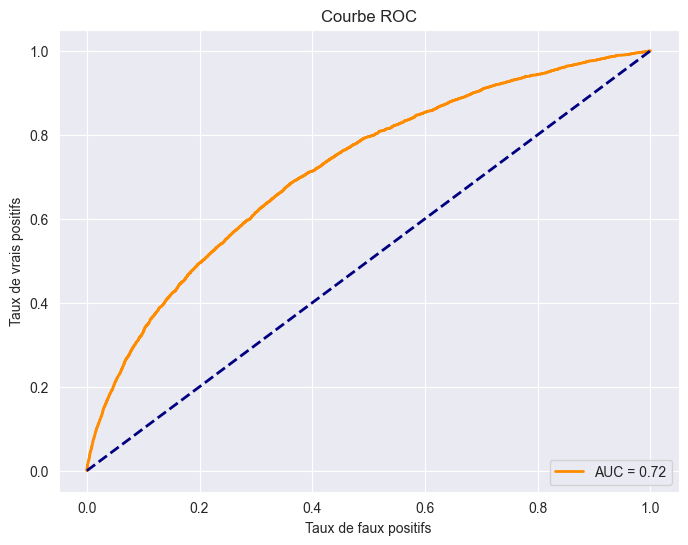

In [124]:
import xgboost as xgb
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

params = {'max_depth': 7, 'eta': 0.3619081800824767, 'gamma': 6.977954148681437e-06, 'colsample_bytree': 0.8736582384510414, 'subsample': 0.6583654387290991, 'n_estimators': 143, 'alpha': 0.19270106587750738}

params = study.best_params

# Créer le modèle avec les hyperparamètres spécifiés
model = xgb.XGBClassifier(**params)

# Entraîner le modèle
model.fit(X_train2[liste_var], y_train)

# Faire des prédictions sur l'ensemble de test
y_prob = model.predict_proba(X_test2[liste_var])[:, 1]

# Calculer la courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Afficher la courbe ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbe ROC')
plt.legend(loc='lower right')
plt.show()

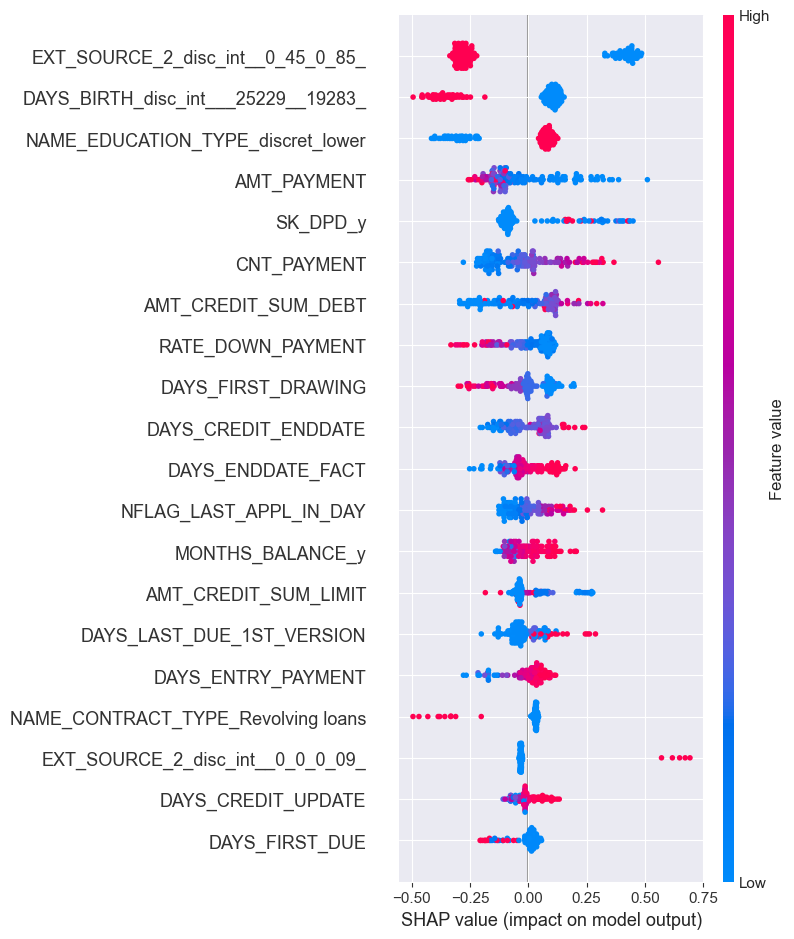

In [125]:
import shap


explainer = shap.TreeExplainer(model)

# Calculer les Shapley values pour un échantillon de données (par exemple, les 100 premières observations)
shap_values = explainer.shap_values(X_train2[liste_var].iloc[:150, :])

# Afficher les Shapley values pour la première observation
shap.summary_plot(shap_values, X_train2[liste_var].iloc[:150, :])

# Si vous voulez expliquer une prédiction spécifique pour une observation donnée, utilisez la fonction shap_values
# par exemple, pour expliquer la prédiction pour la première observation :
shap_values_single = explainer.shap_values(X_train2[liste_var].iloc[[0]])
shap.force_plot(explainer.expected_value, shap_values_single, X_train2[liste_var].iloc[[0]])

In [127]:
import numpy as np
shap_values_avg = np.abs(shap_values).mean(axis=0)
top_variables_indices = np.argsort(shap_values_avg)[::-1]


n_top_variables = 20
top_variables = X_train2[liste_var].columns[top_variables_indices[:n_top_variables]]

top_variables

Index(['EXT_SOURCE_2_disc_int__0_45_0_85_',
       'DAYS_BIRTH_disc_int___25229__19283_',
       'NAME_EDUCATION_TYPE_discret_lower', 'AMT_PAYMENT', 'SK_DPD_y',
       'CNT_PAYMENT', 'AMT_CREDIT_SUM_DEBT', 'RATE_DOWN_PAYMENT',
       'DAYS_FIRST_DRAWING', 'DAYS_CREDIT_ENDDATE', 'DAYS_ENDDATE_FACT',
       'NFLAG_LAST_APPL_IN_DAY', 'MONTHS_BALANCE_y', 'AMT_CREDIT_SUM_LIMIT',
       'DAYS_LAST_DUE_1ST_VERSION', 'DAYS_ENTRY_PAYMENT',
       'NAME_CONTRACT_TYPE_Revolving loans',
       'EXT_SOURCE_2_disc_int__0_0_0_09_', 'DAYS_CREDIT_UPDATE',
       'DAYS_FIRST_DUE'],
      dtype='object')